# Measurements Reindexing Mainnet

These measurements were made on a full node on GCP (Google Compute) reindexing mainnet.

The host is type `n1-standard-1` which means:
 * 1 virtual CPU (pinned to the host CPU)
 * 4096 MB of RAM, of which about 3.6 GB is available to userspace
 * Very slow disks (connected to some kind of SAN)
 
Bitcoin itself is configured with `dbcache=2048`.

## Motivation

The motivation here is to make IBD work better on machines with slow disks. For instance, on most cloud instances IBD will be extremely I/O bound, to the point that it's basically impossible to actually finish syncing a node. This is true even on hosts that have a relatively large amount of memory, and therefore ought to be able ot keep most of the dataset in memory.

## A Priori Memory Predictions

How much memory would we expect the UTXO set to use if it was fully loaded into memory? We can calculate this with the size of keys/values and the number of entries in the UTXO set.

Even on hosts that don't have this much memory for their dbcache, hosts that have a reasonable proportion of that memory (e.g. 50% of it) ought to see a big speedup.

In [36]:
coutpoint_size = 36  # sizeof(COutPoint)
cache_entry_size = 56  # sizeof(CCoinsCacheEntry)
current_utxo_size = 57.3e6  # approximate number of entries in the current uxto set
estimated_map_size = (coutpoint_size + cache_entry_size) * current_utxo_size
print('Estimated memory: {:1.2f} GB'.format(estimated_map_size / (1<<30)))

Estimated memory: 4.91 GB


Note that this estimate assumes no overhead for the space taken by the hash table itself. Therefore we should consider it a lower bound on the amount of memory that would be needed. Given a properly tuned hash table though the real world results shouldn't take that much more memory.

## Measurements

In [37]:
%matplotlib inline

import os
import pickle

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

matplotlib.rcParams['figure.dpi']= 300
matplotlib.rcParams['figure.figsize'] = [12, 8]

with open('data.pkl', 'rb') as pkl_file:
    data = pickle.load(pkl_file)
frames = data['frames']
globals().update(frames)

print('Using data generated from {}'.format(data['filename']))
print('Available frames: {}'.format(' '.join(sorted(frames.keys()))))

Using data generated from bitcoin-core-1518930964.log
Available frames: cache flushes ioreqs updatetip vfstime


In [38]:
# Information about CCoinsCacheView flushes
flushes.head()

,num_bytes,num_coins
2018-02-18 01:02:09.866536,2437160176,16892384


In [39]:
flushtimes = flushes.index.tolist()

def plot(df, color='k', title=None, show_flush=True):
    """Generate a plot from a datafame, with flushes overlaid."""
    plt.figure()
    df.plot(title=title)
    if show_flush:
        for t in flushtimes:
            plt.axvline(x=t, color=color, linestyle=':')

### Indexing Rate (Height)

In this section we'll look at how fast the chain is syncing, measured by the chain height.

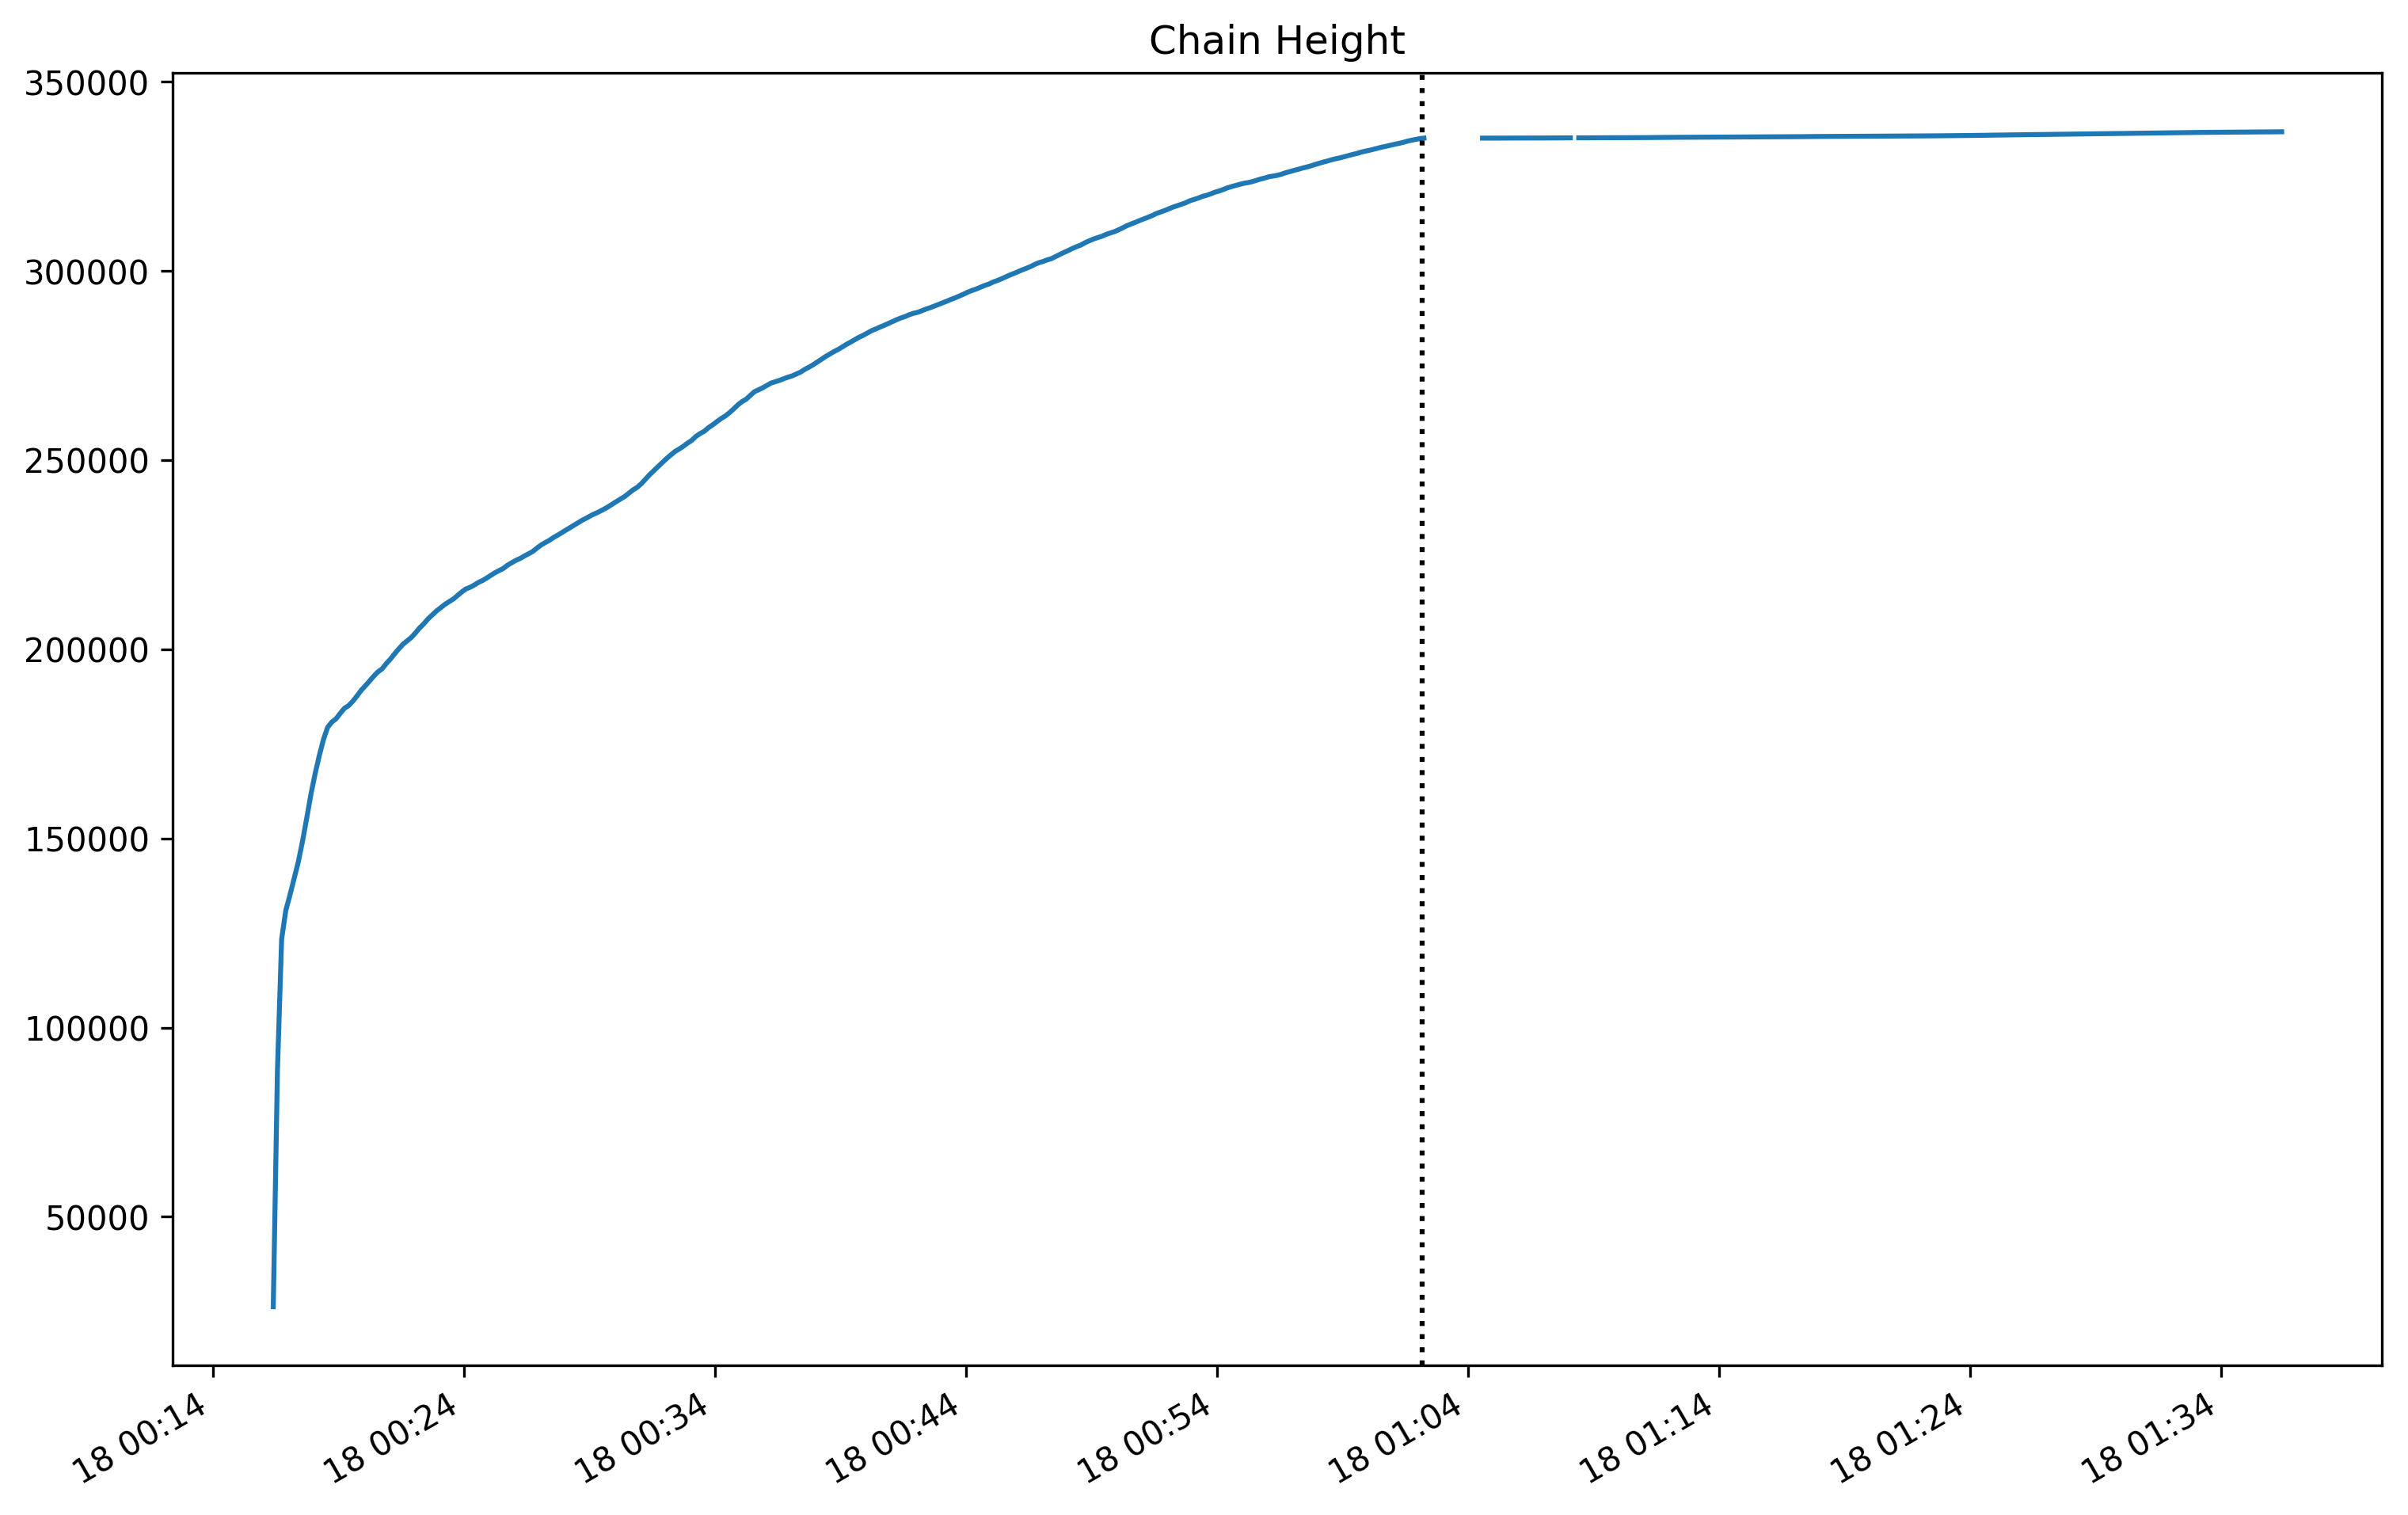

In [40]:
plot(updatetip['height'], title='Chain Height')

In [41]:
if False:
    times = np.array(update_tip.index.to_series())
    front = times[:-1]
    back = times[1:]
    ns_per_block = back - front
    blocks_per_s = (1e9/ns_per_block.astype(int))
    df = pd.DataFrame({'blocks_per_second': blocks_per_s}, index=back)
    plot(df.rolling(10).mean(), title='Blocks Indexed Per Second')

### Indexing Rate (via "Progress" estimate)

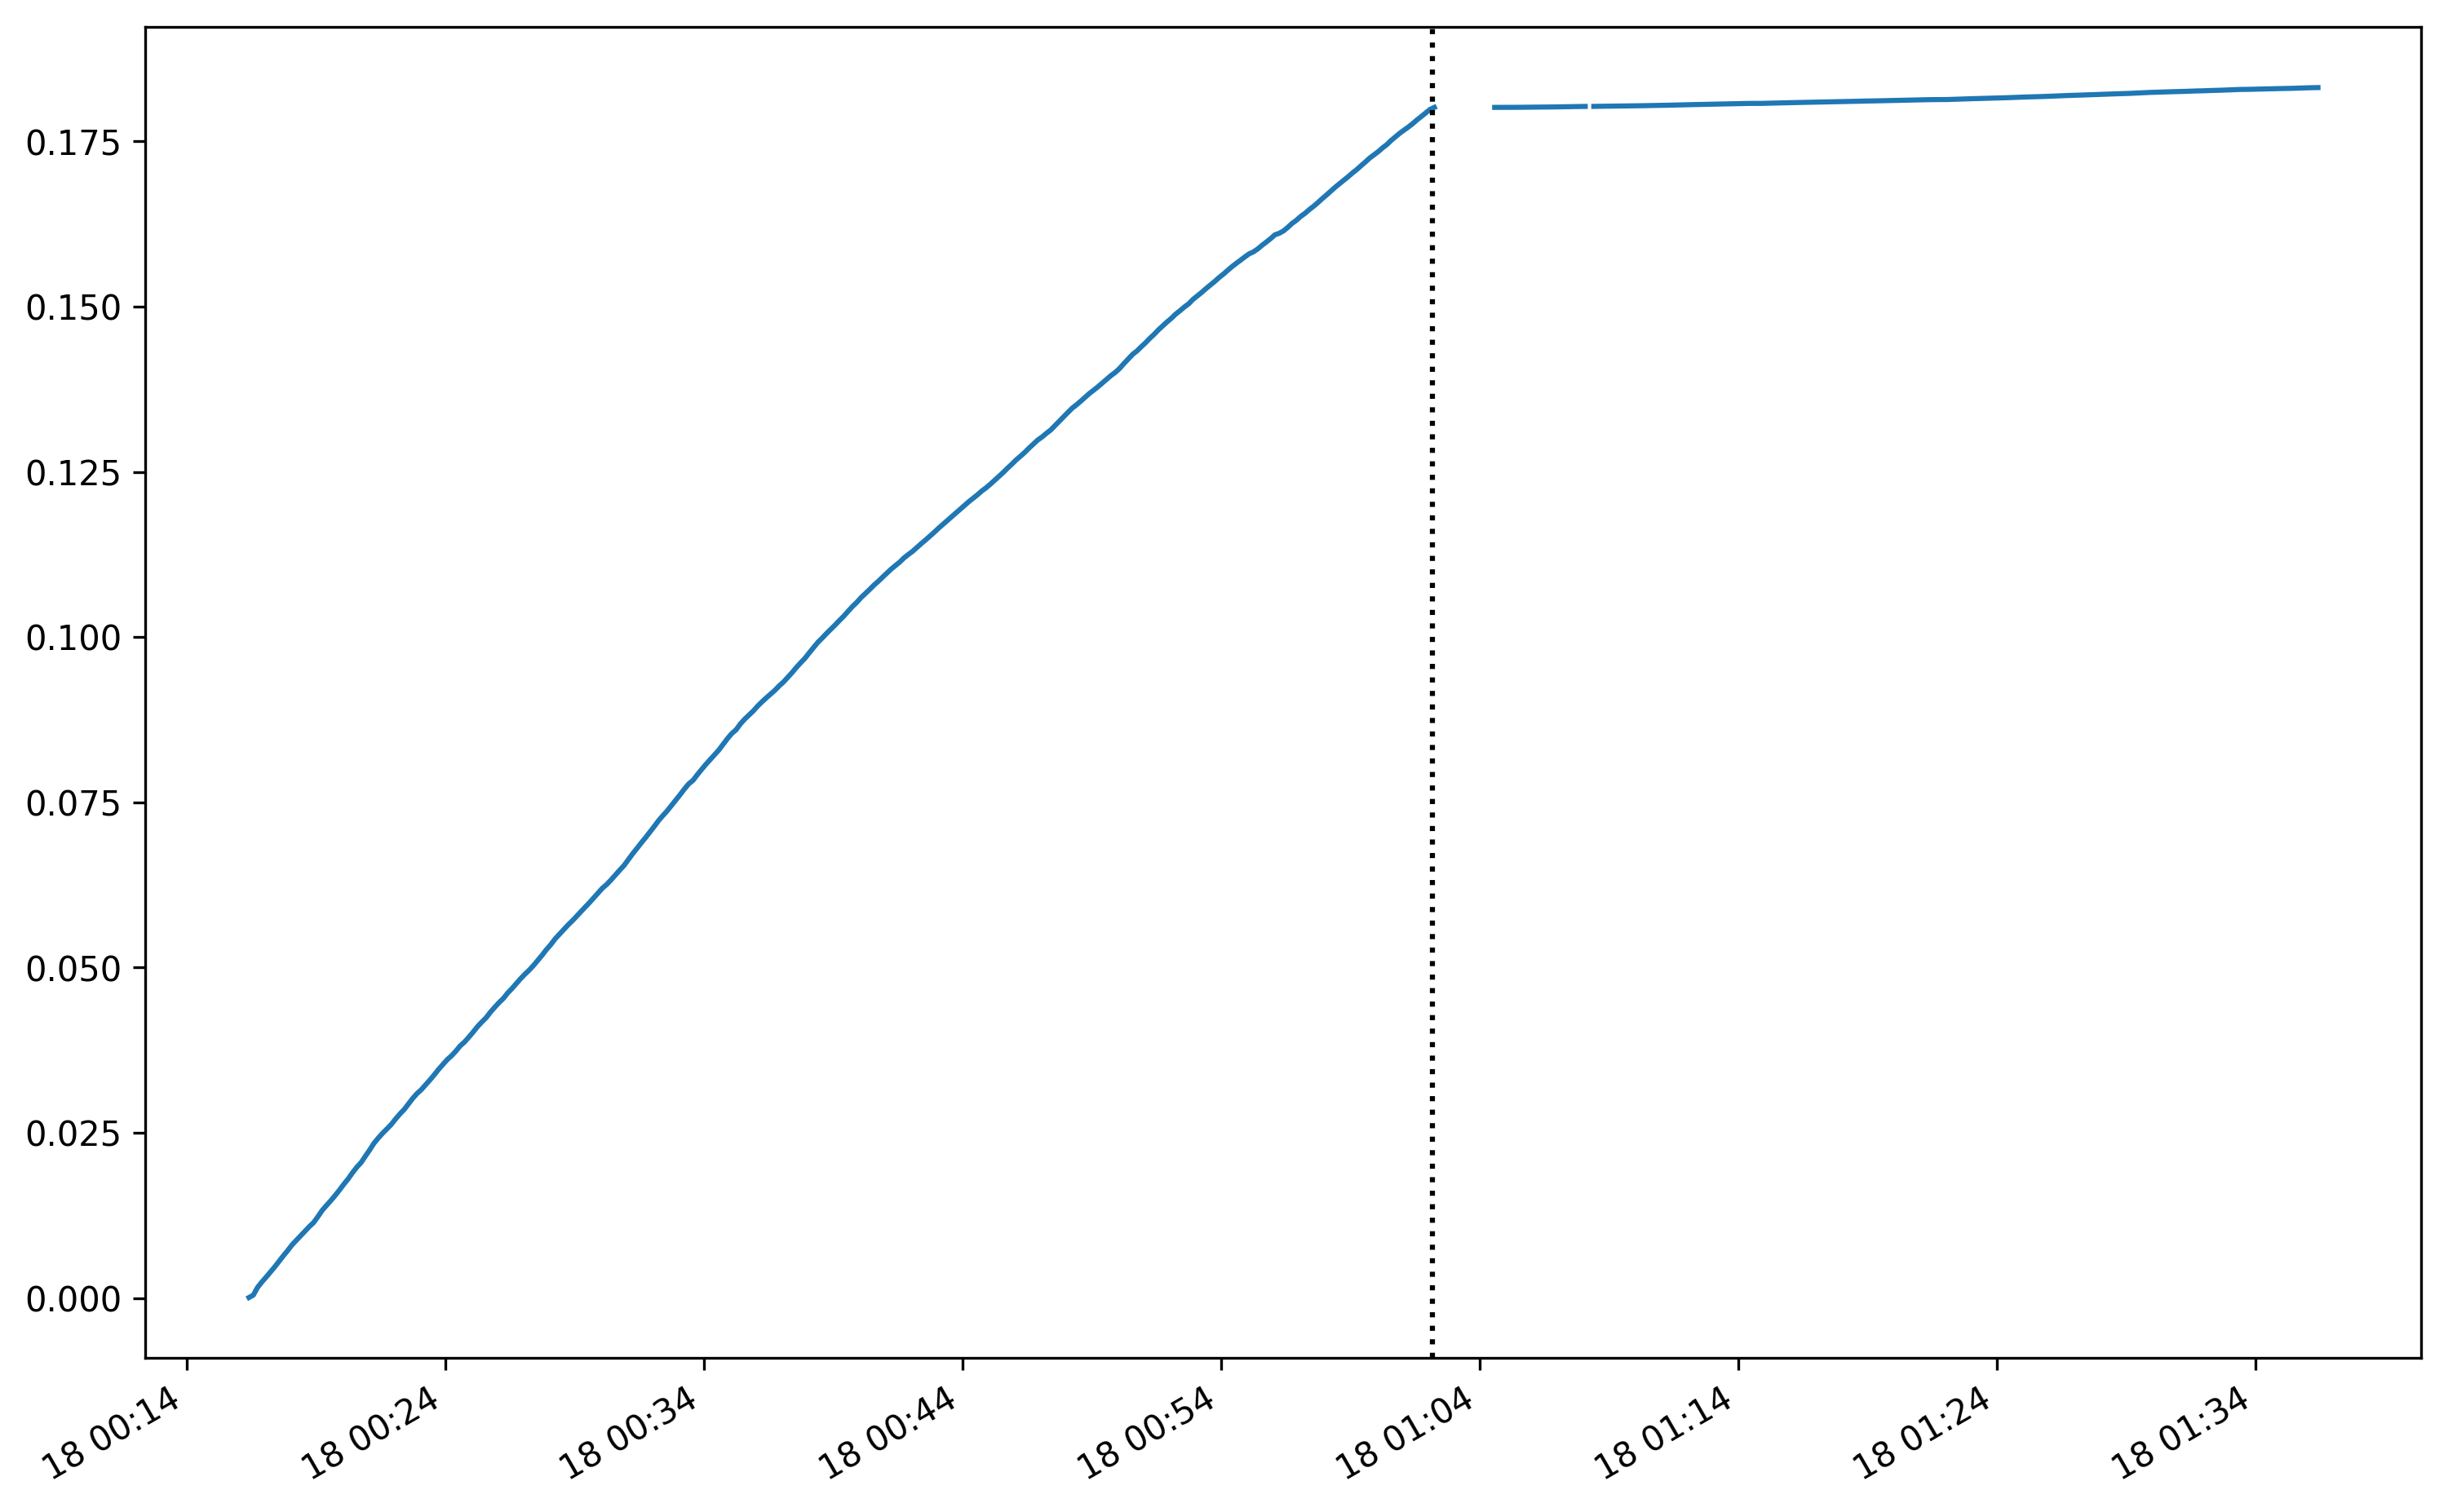

In [42]:
plot(updatetip['progress'] / 1e6)

### Cache Hits

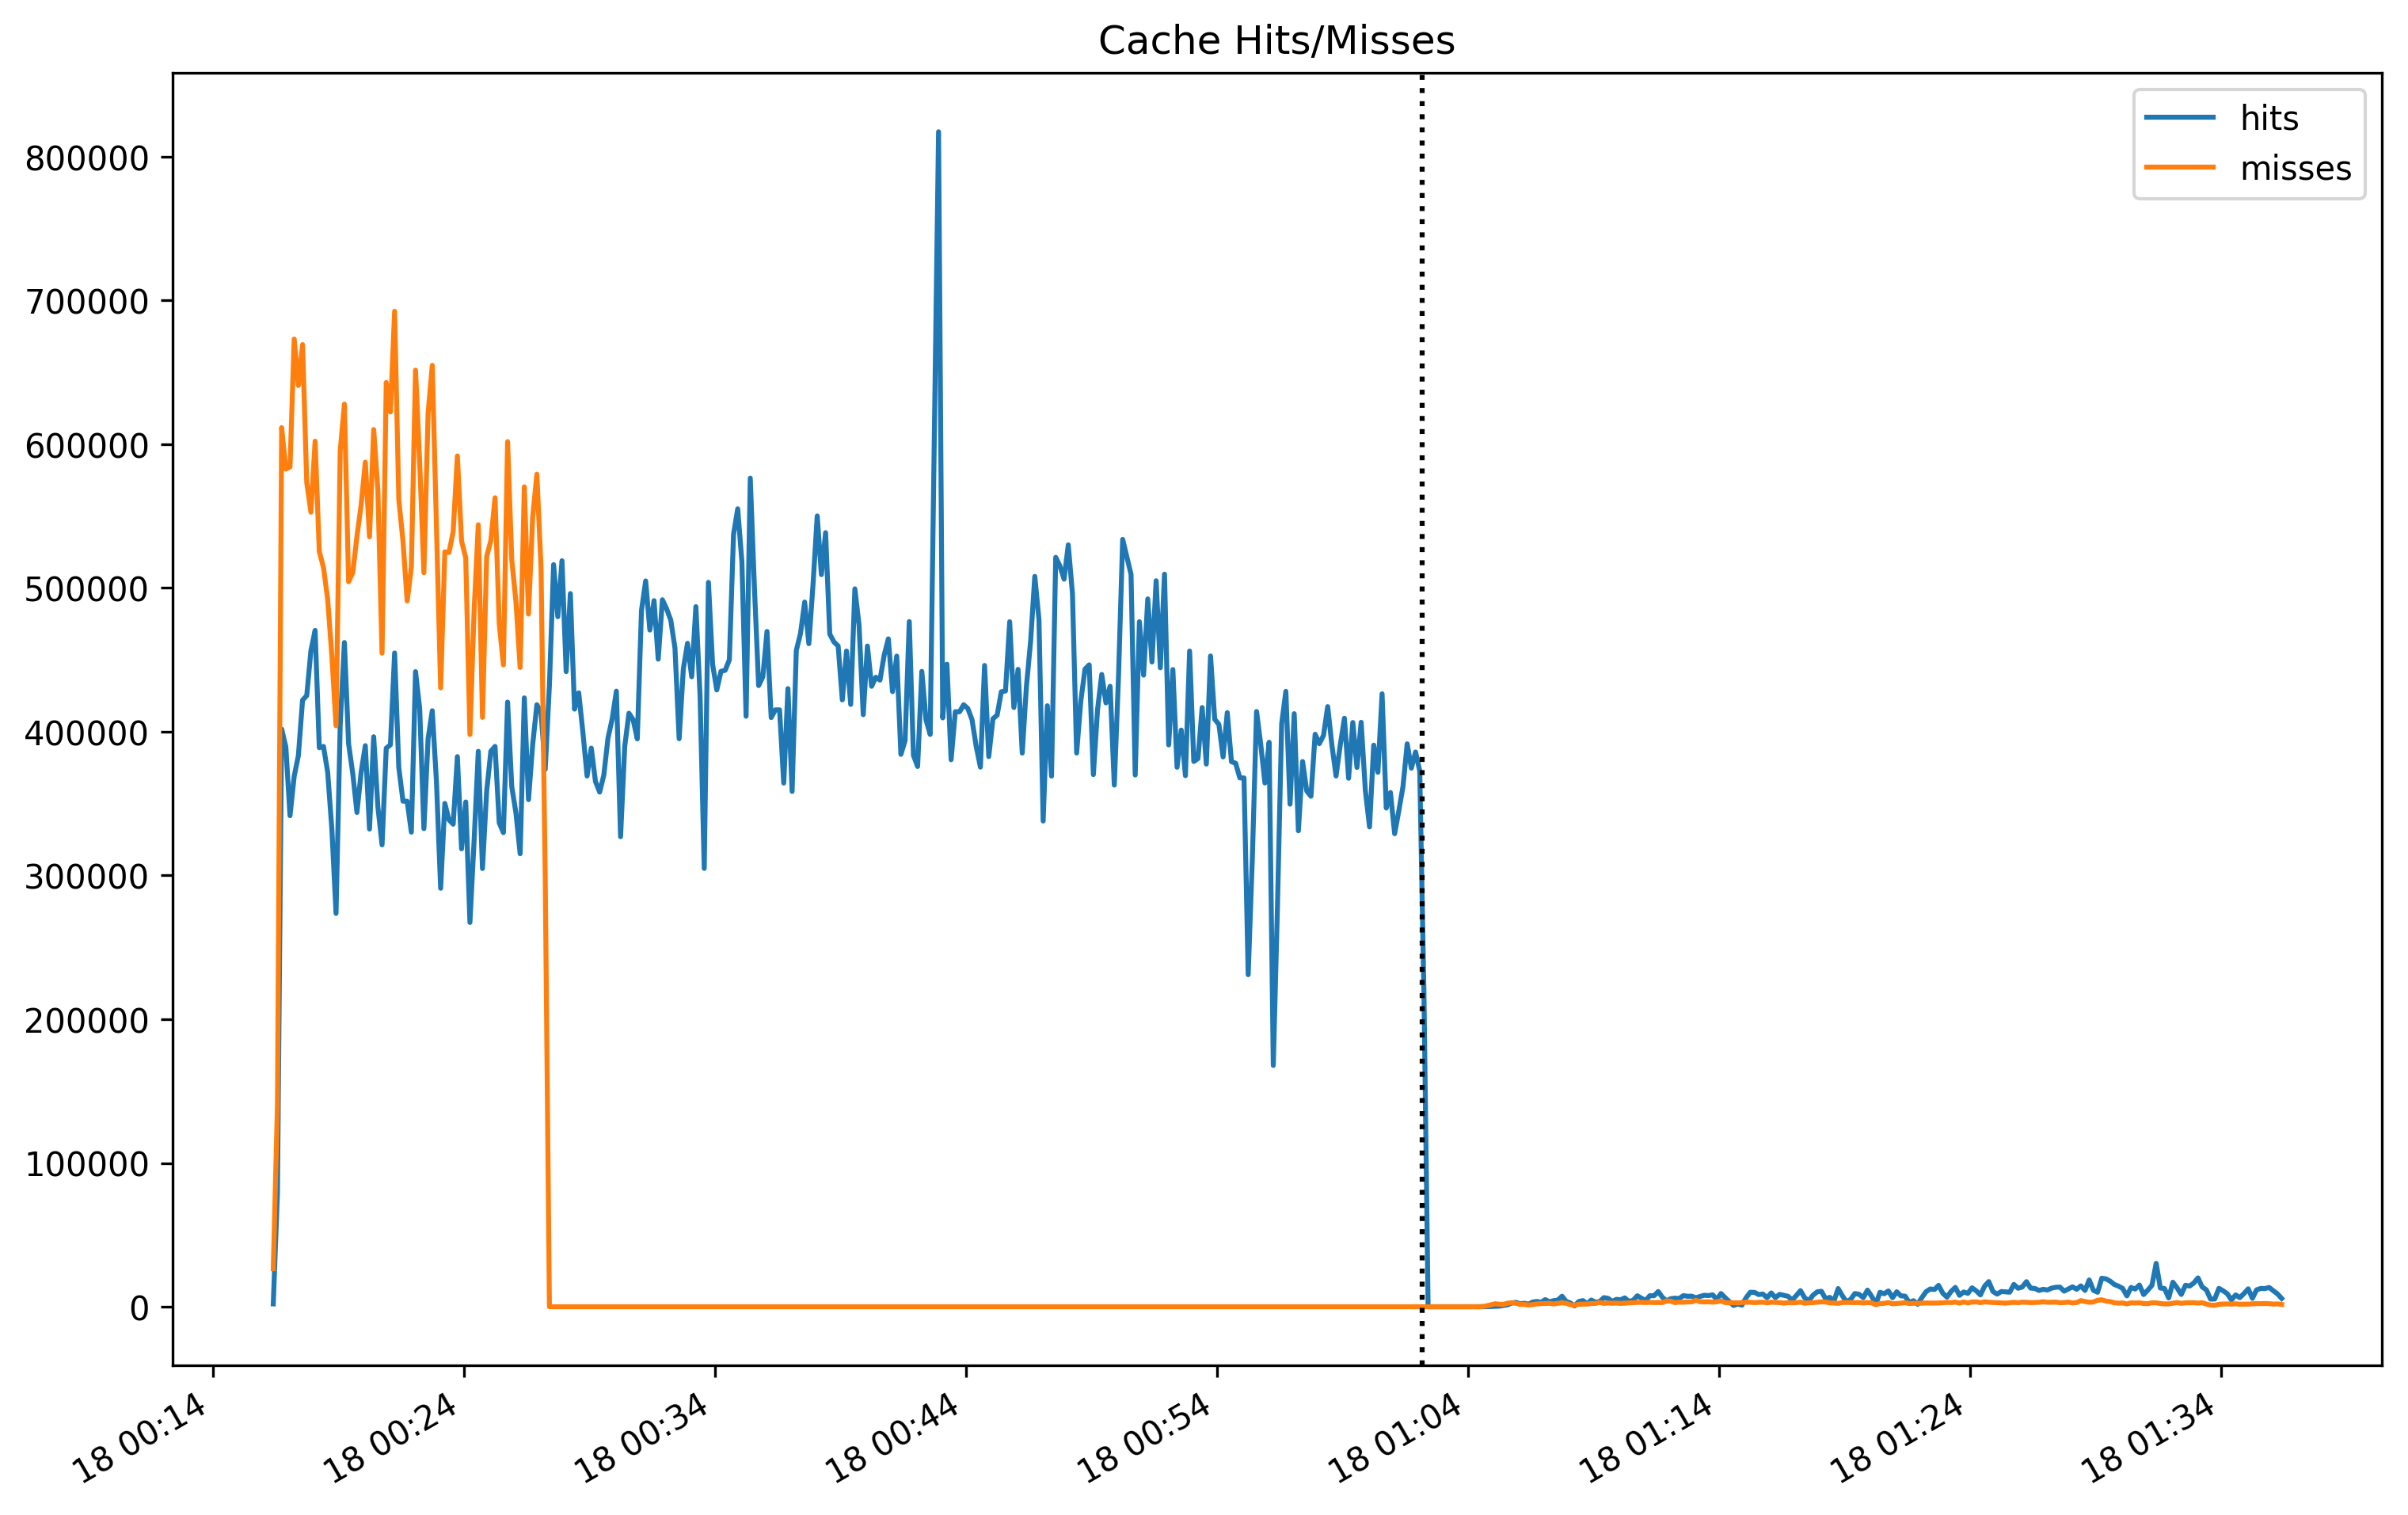

In [43]:
plot(cache, title='Cache Hits/Misses')

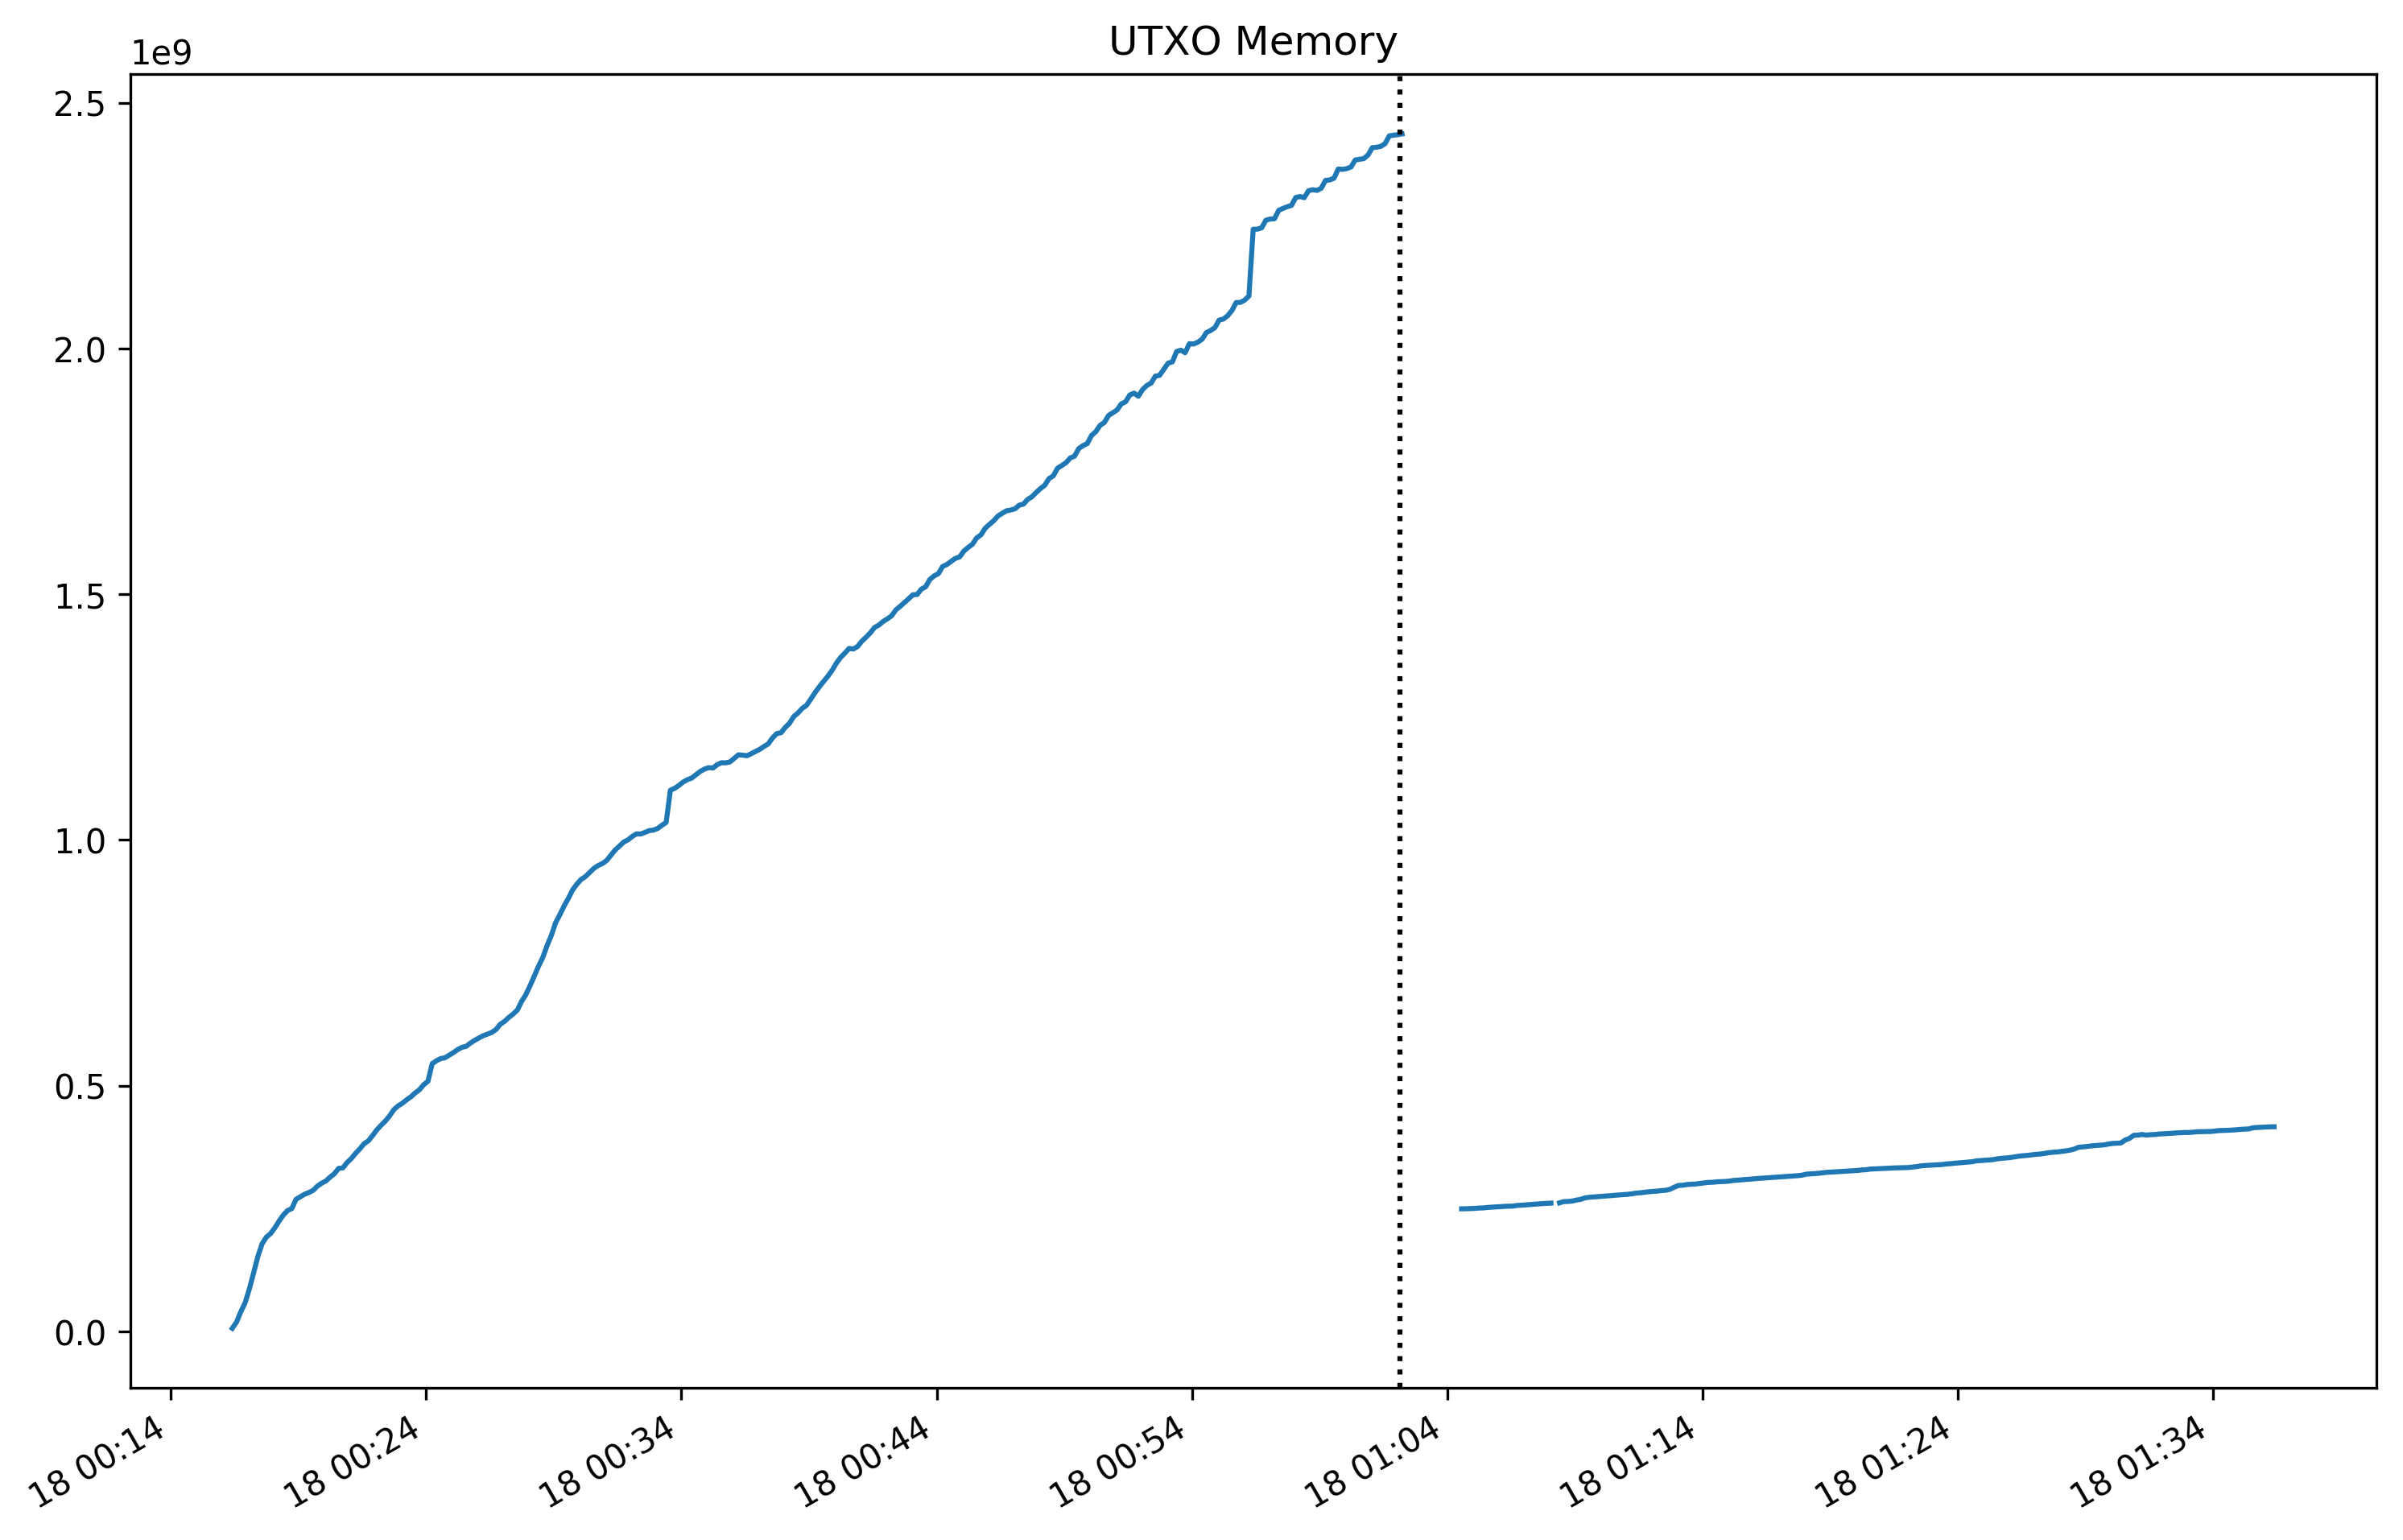

In [44]:
plot(updatetip['utxo_memory'], title='UTXO Memory')

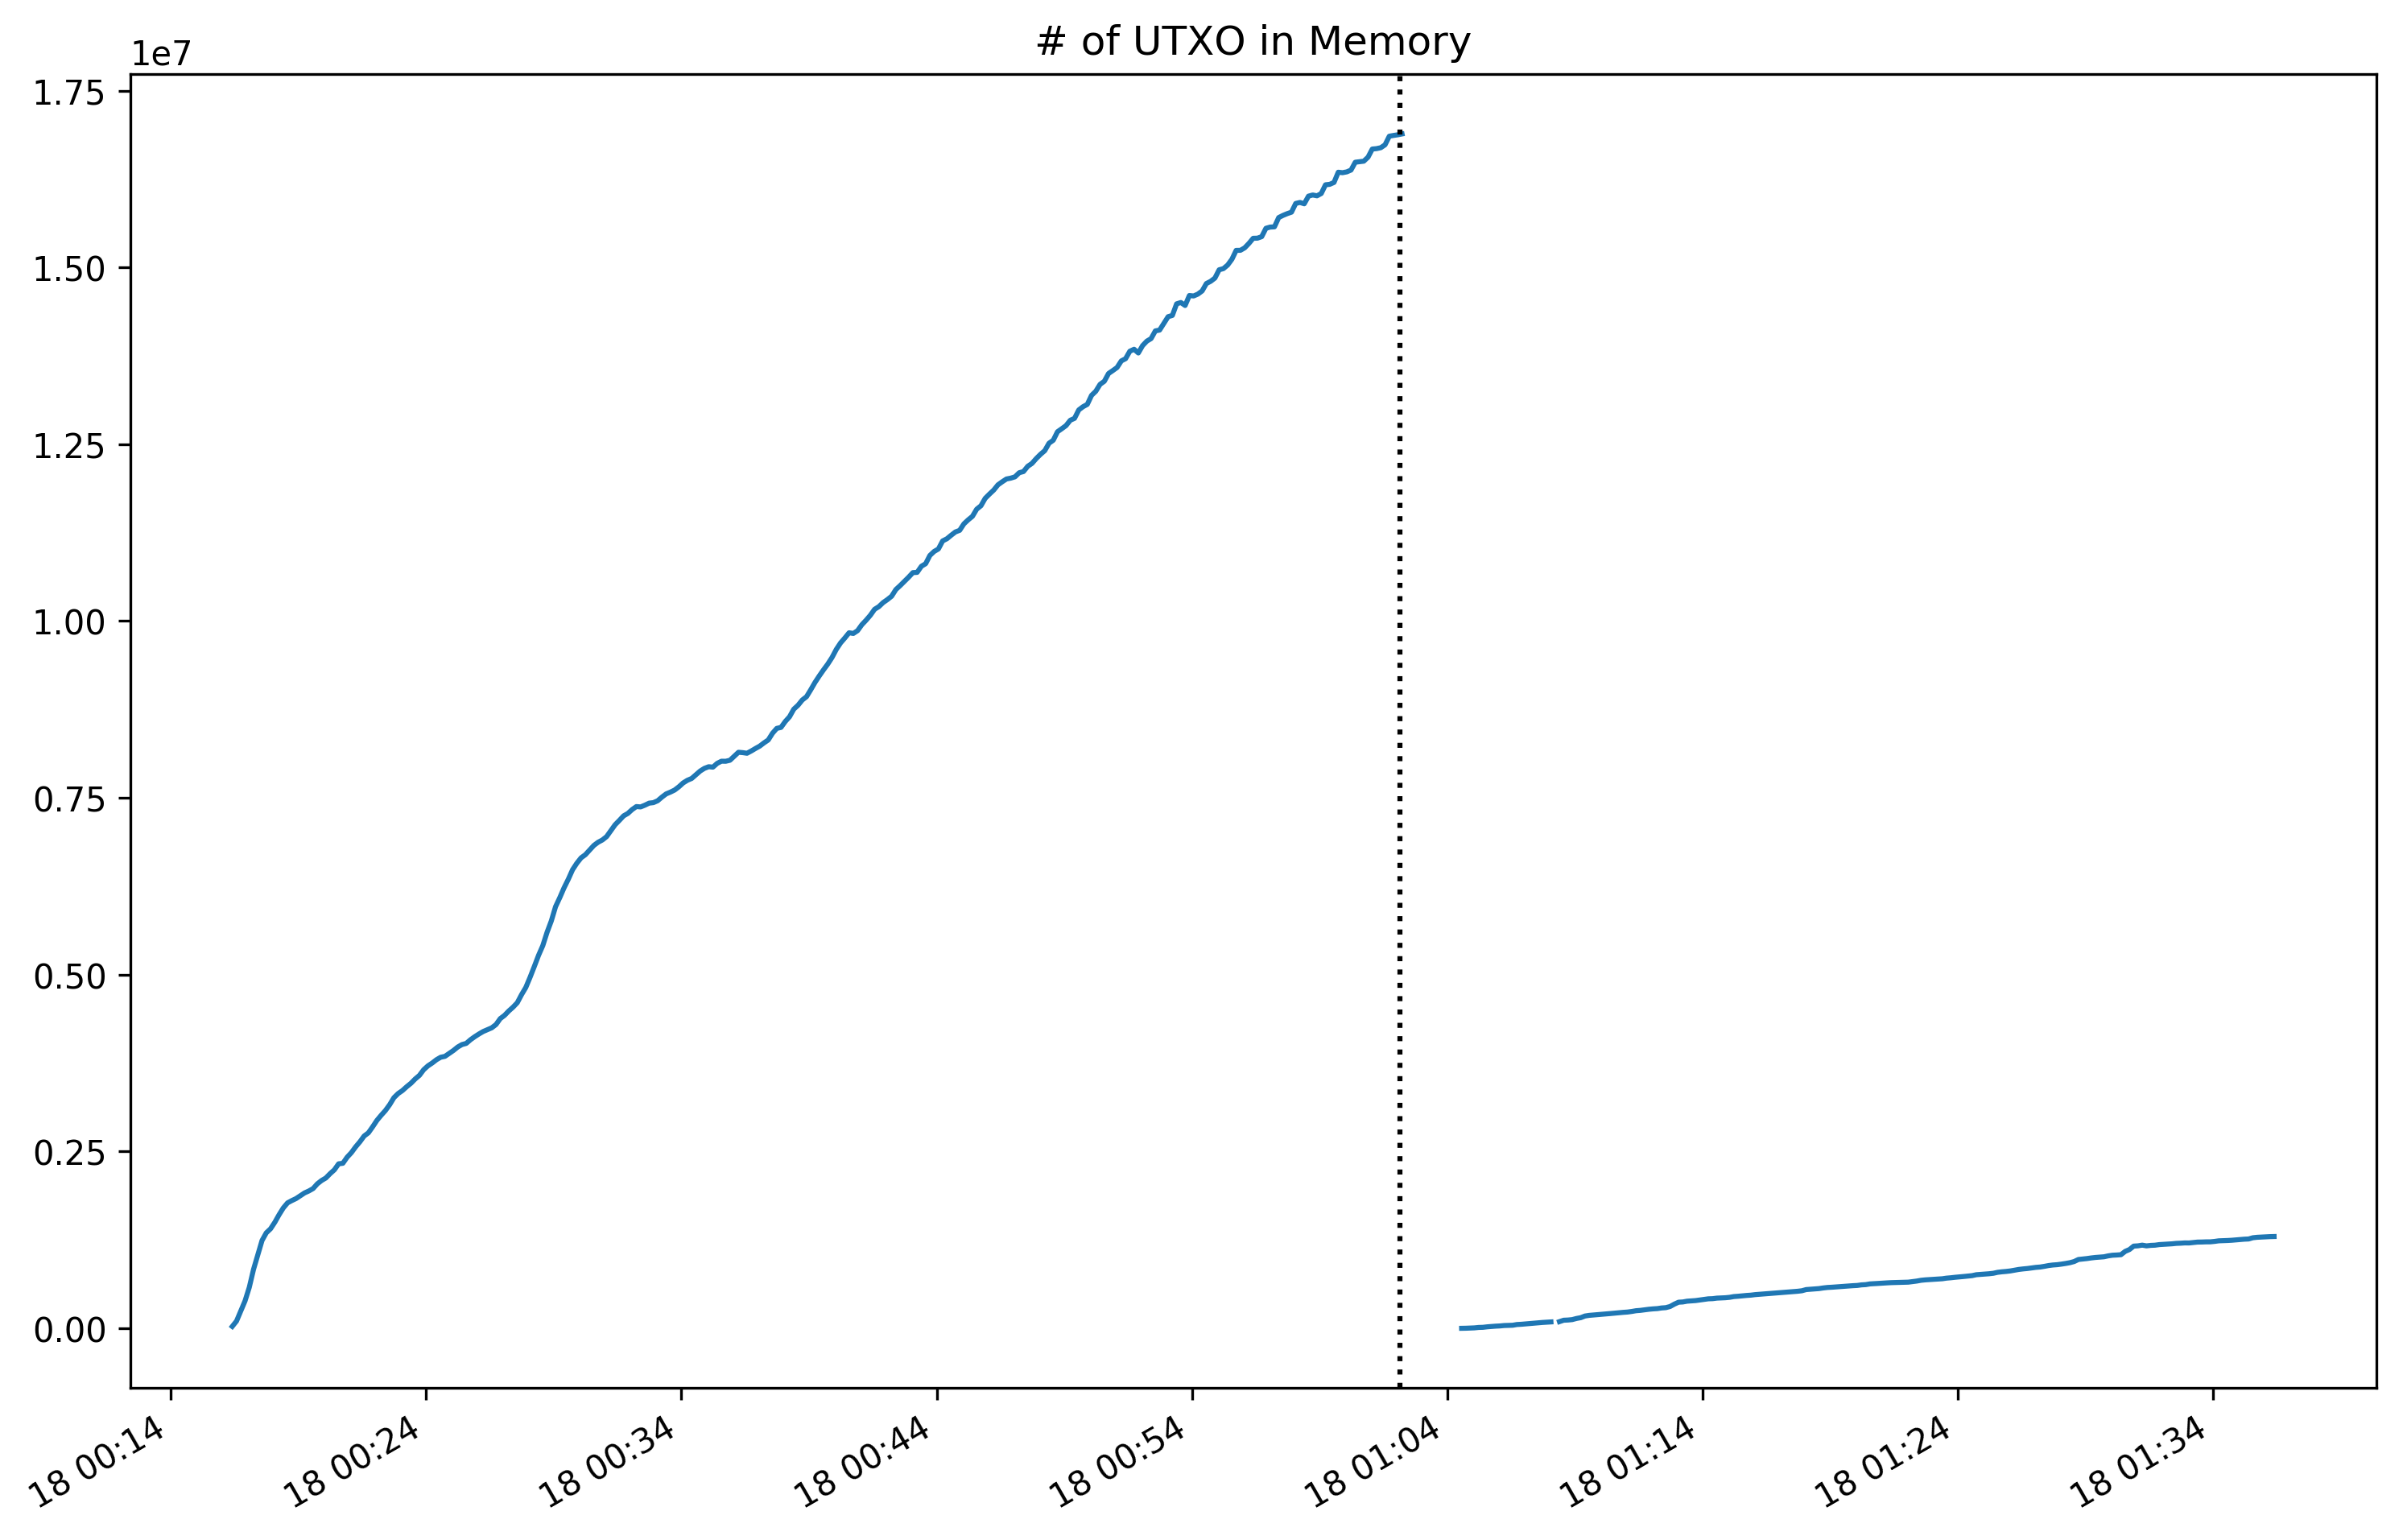

In [45]:
plot(updatetip['utxo_count'], title='# of UTXO in Memory')

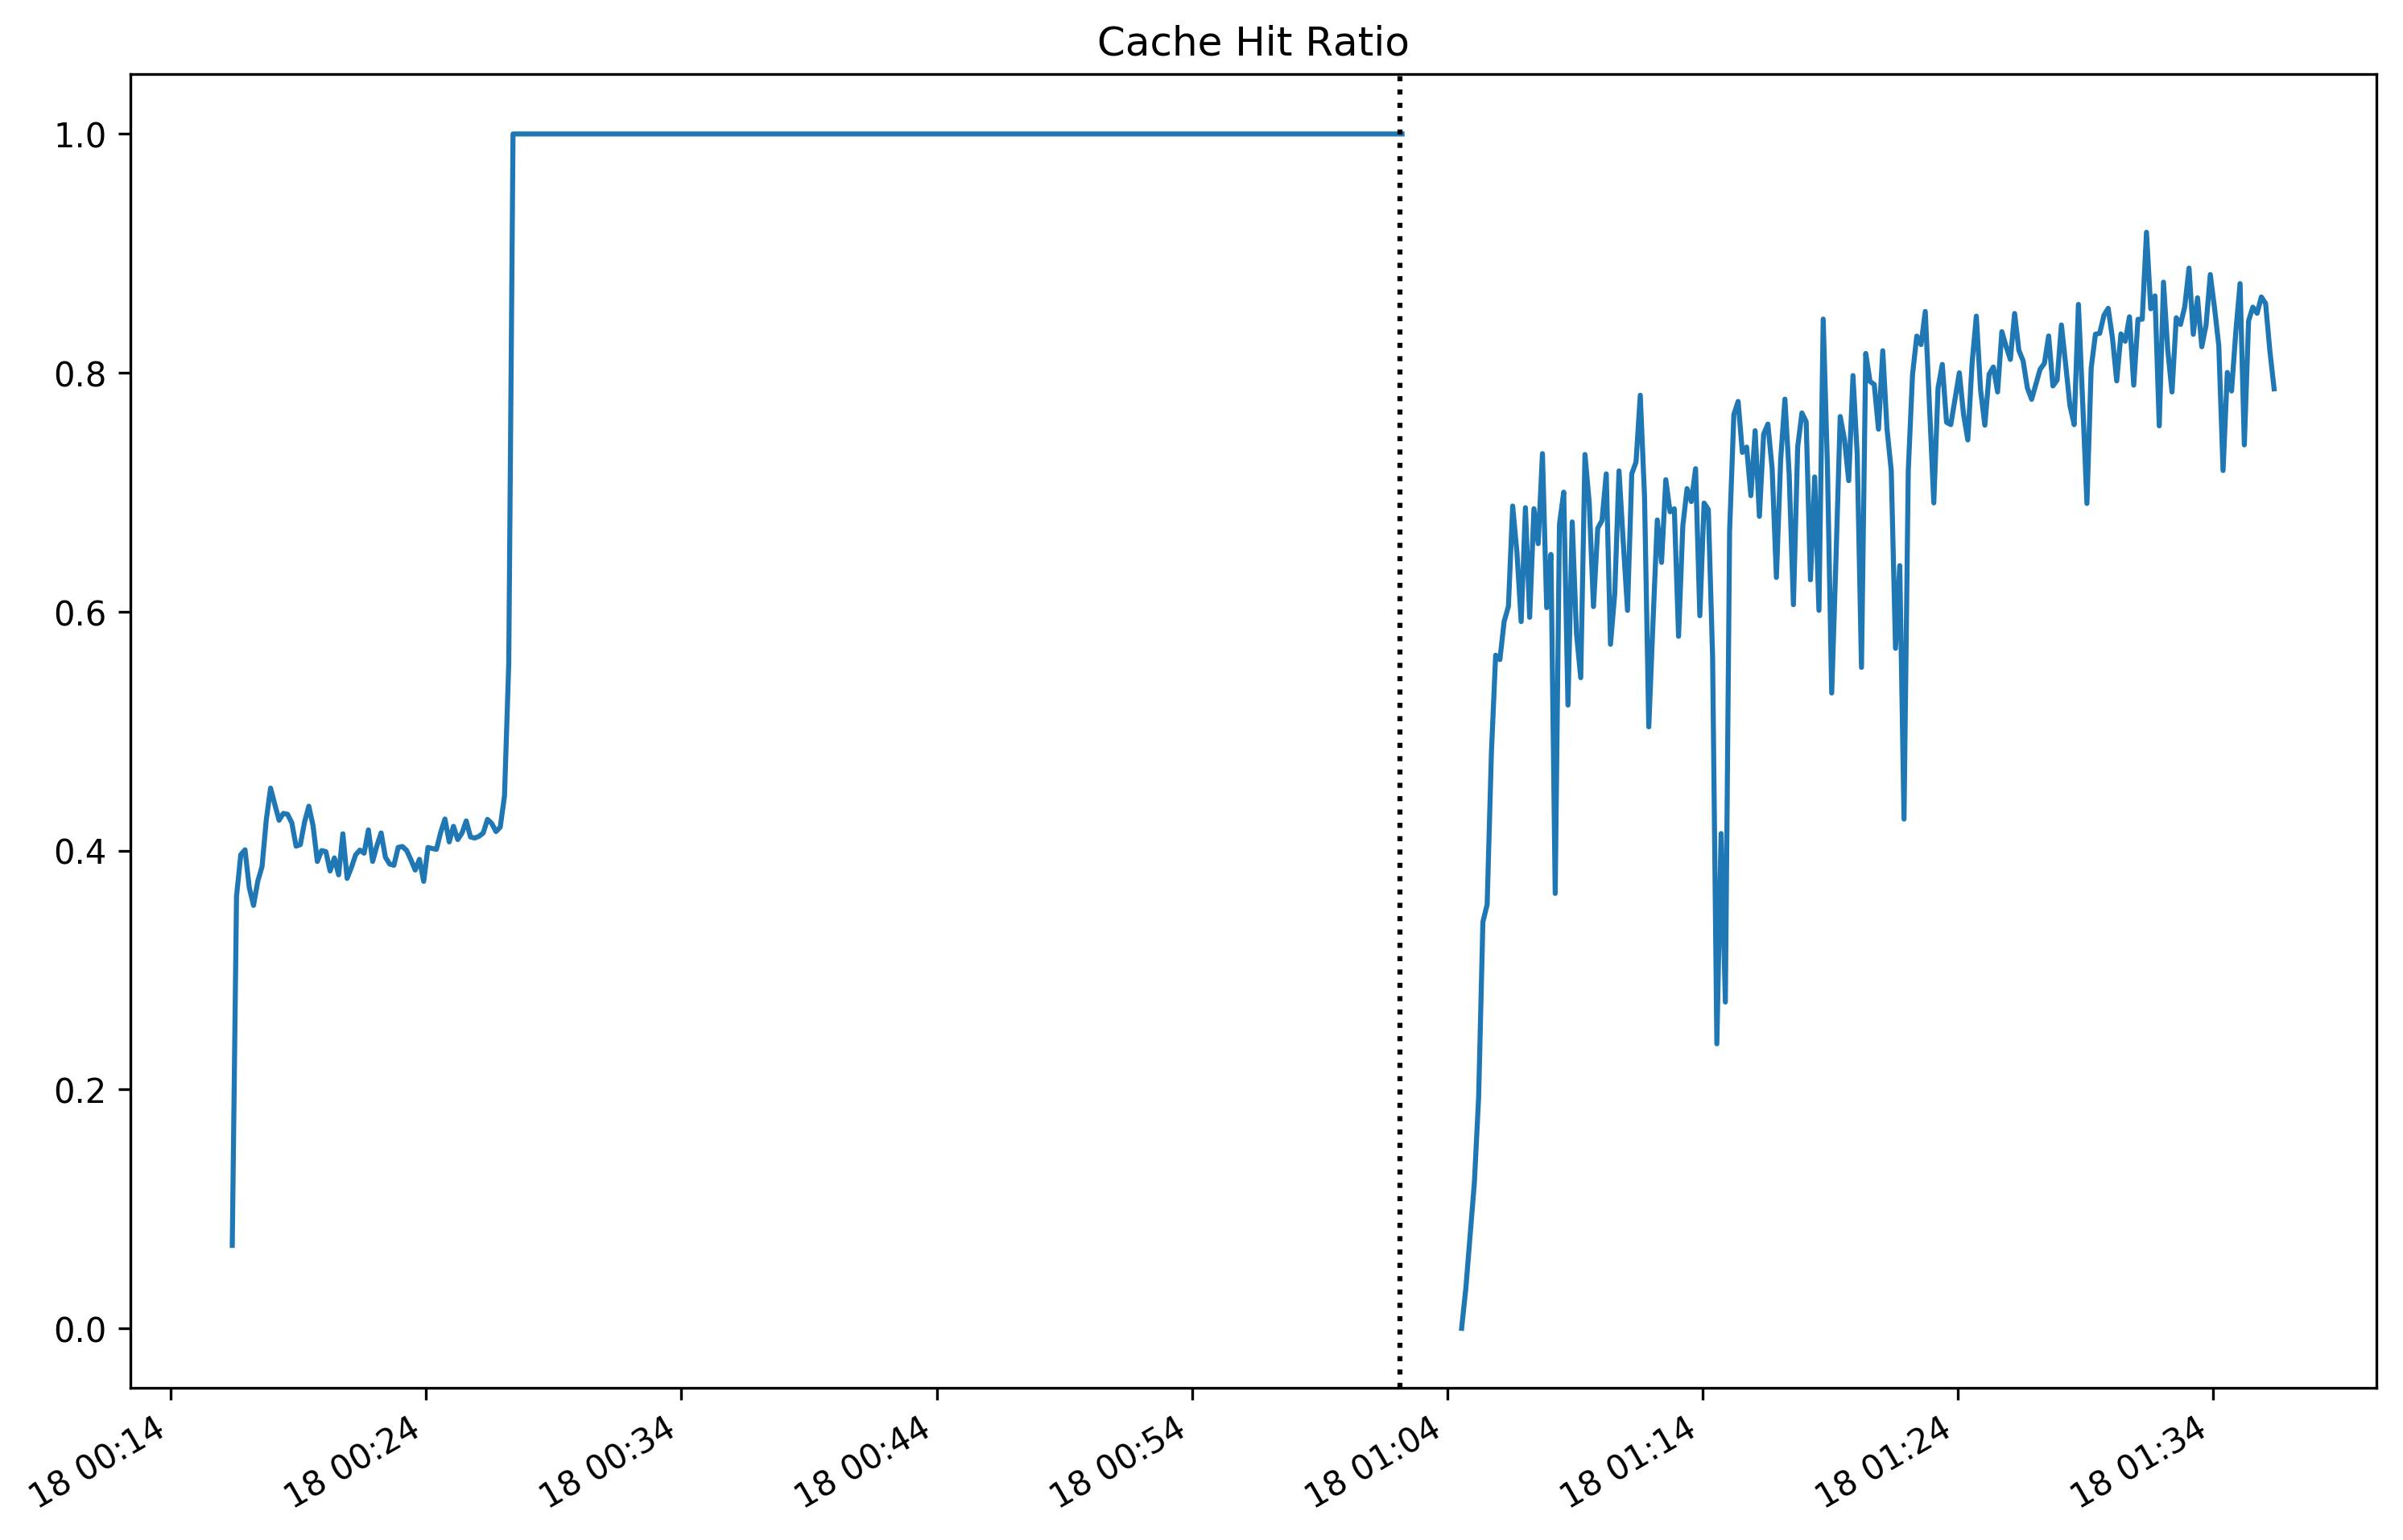

In [46]:
hits = cache['hits']
total = hits + cache['misses']
plot(hits / total, title='Cache Hit Ratio')

In [47]:
sum(hits/sum(total))

0.7634638014081346

## Disk / VFS Stats

In [48]:
ioreqs.head()

,bios,mpage_readpages
2018-02-18 00:16:24.044234,505,0
2018-02-18 00:16:34.044235,10,0
2018-02-18 00:16:44.044235,39,0
2018-02-18 00:16:54.044242,3130,24155
2018-02-18 00:17:04.044234,2827,23761


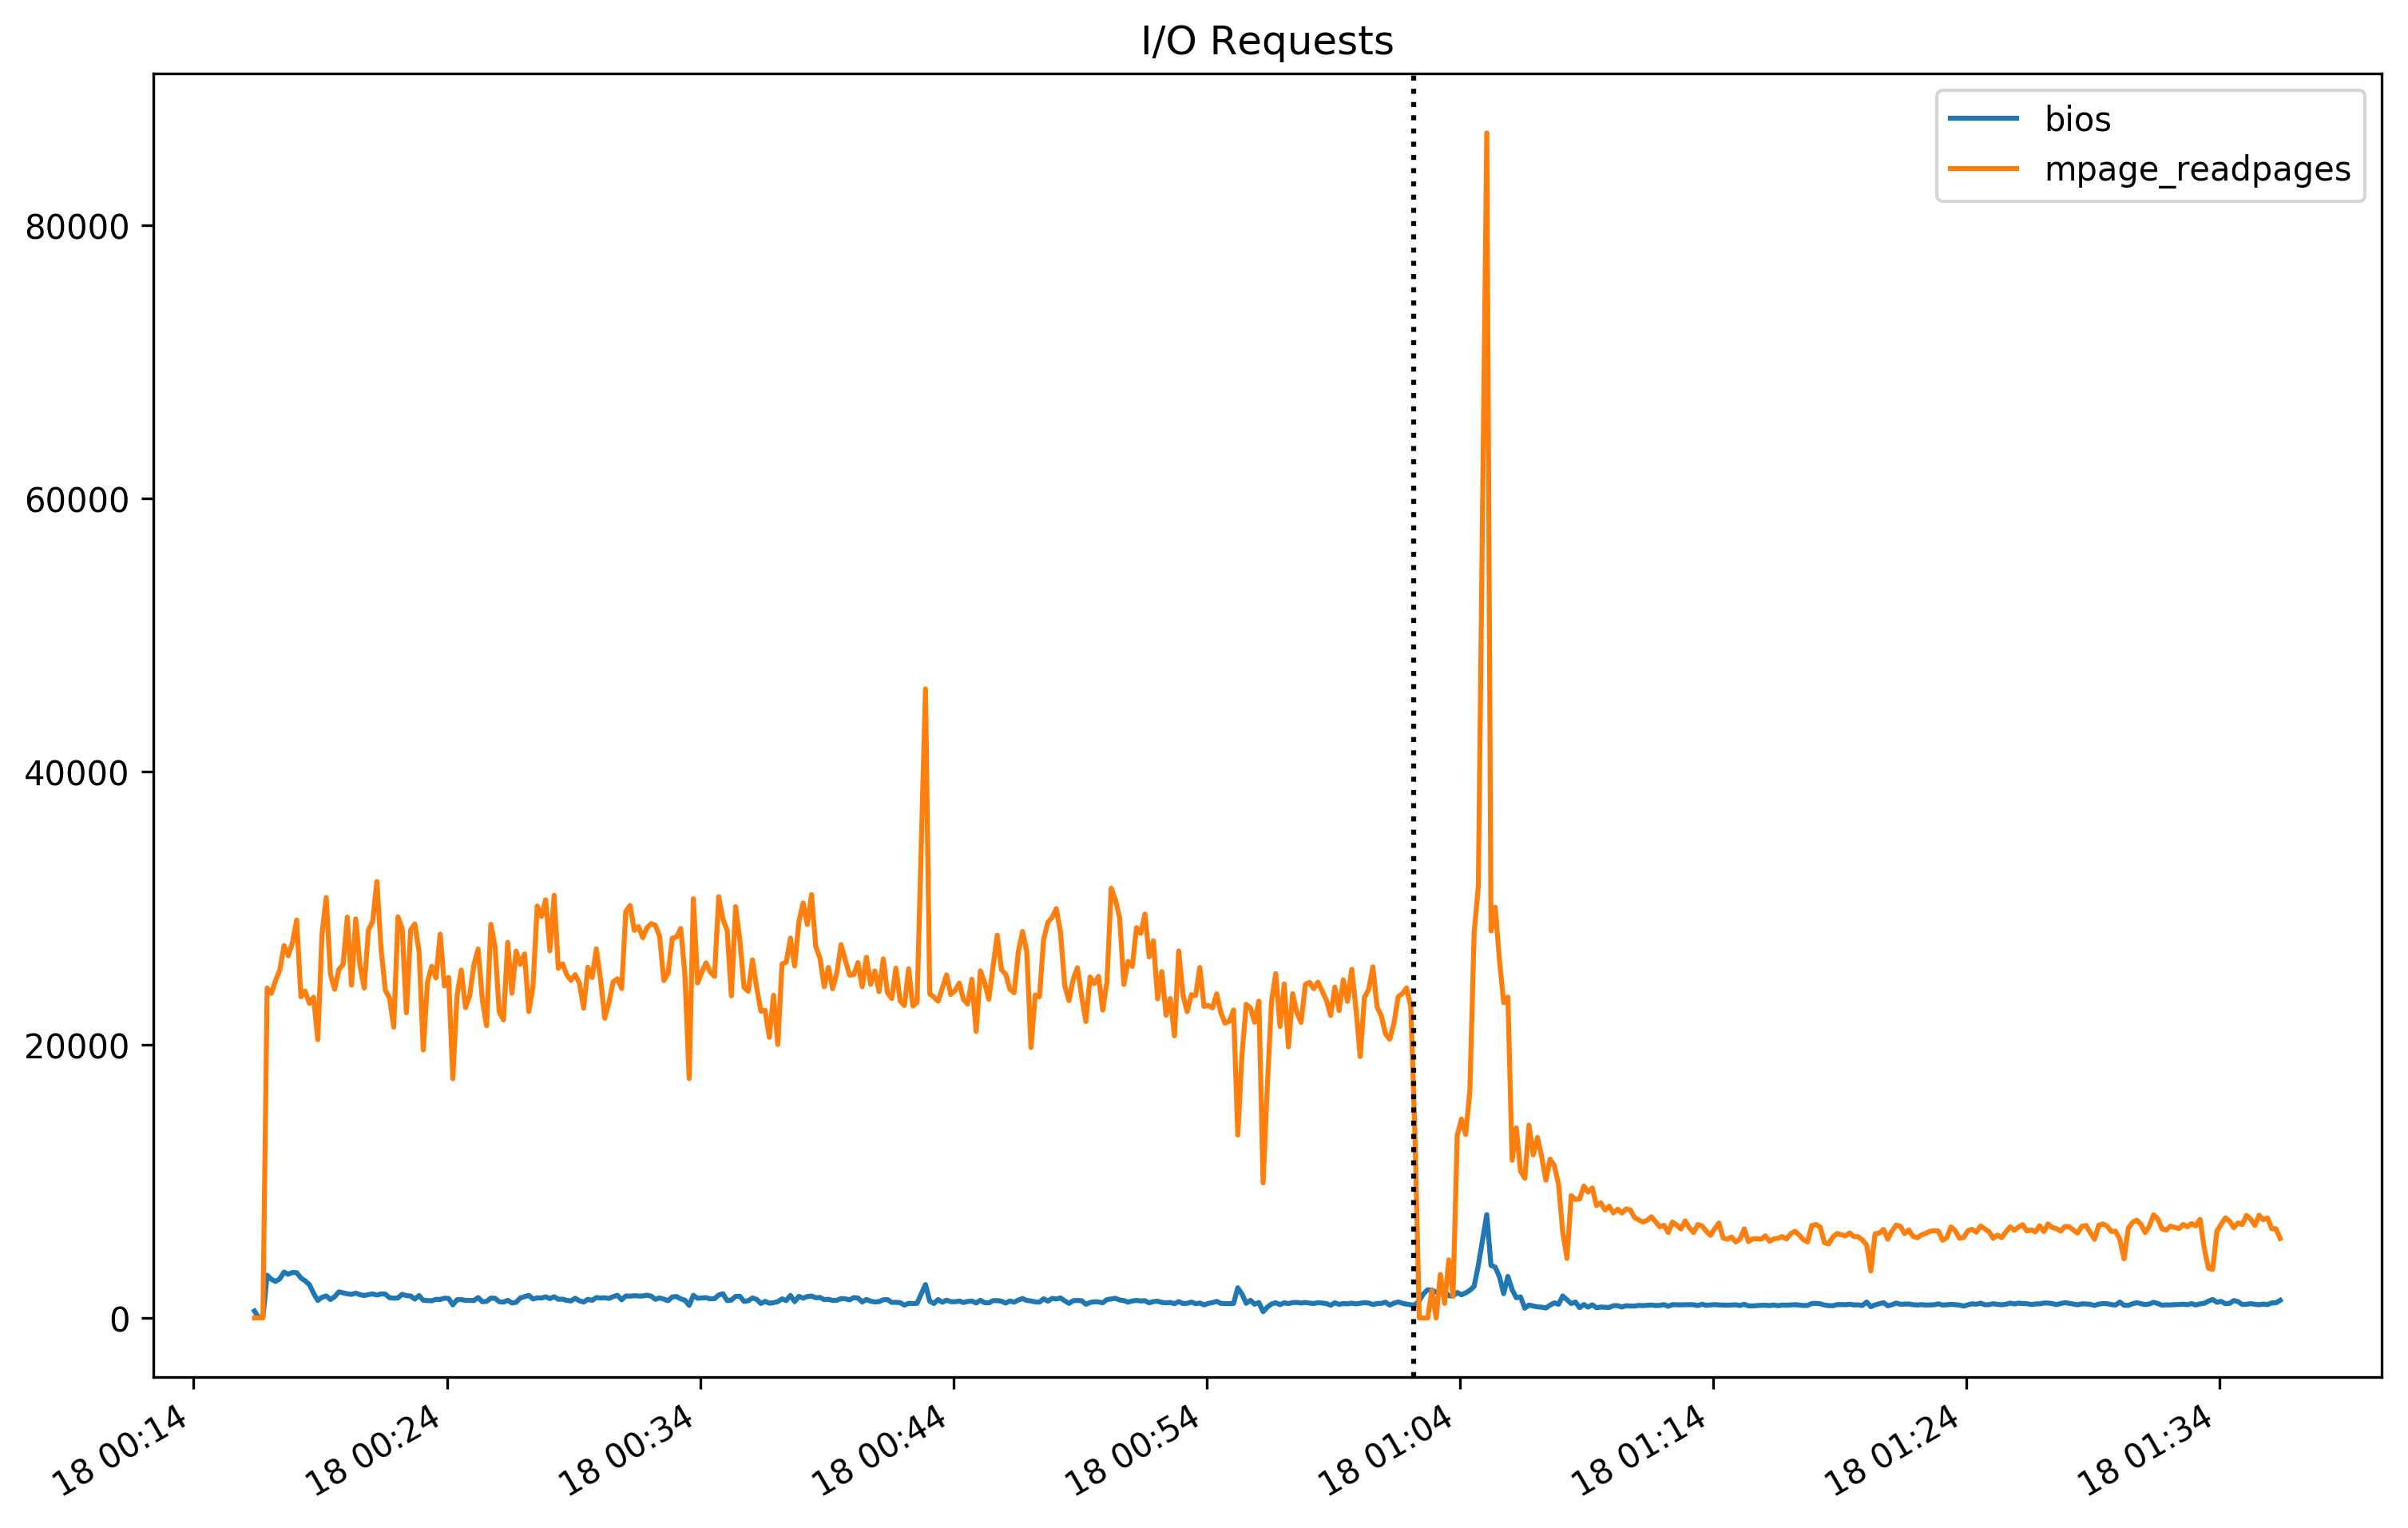

In [49]:
plot(ioreqs, title='I/O Requests')

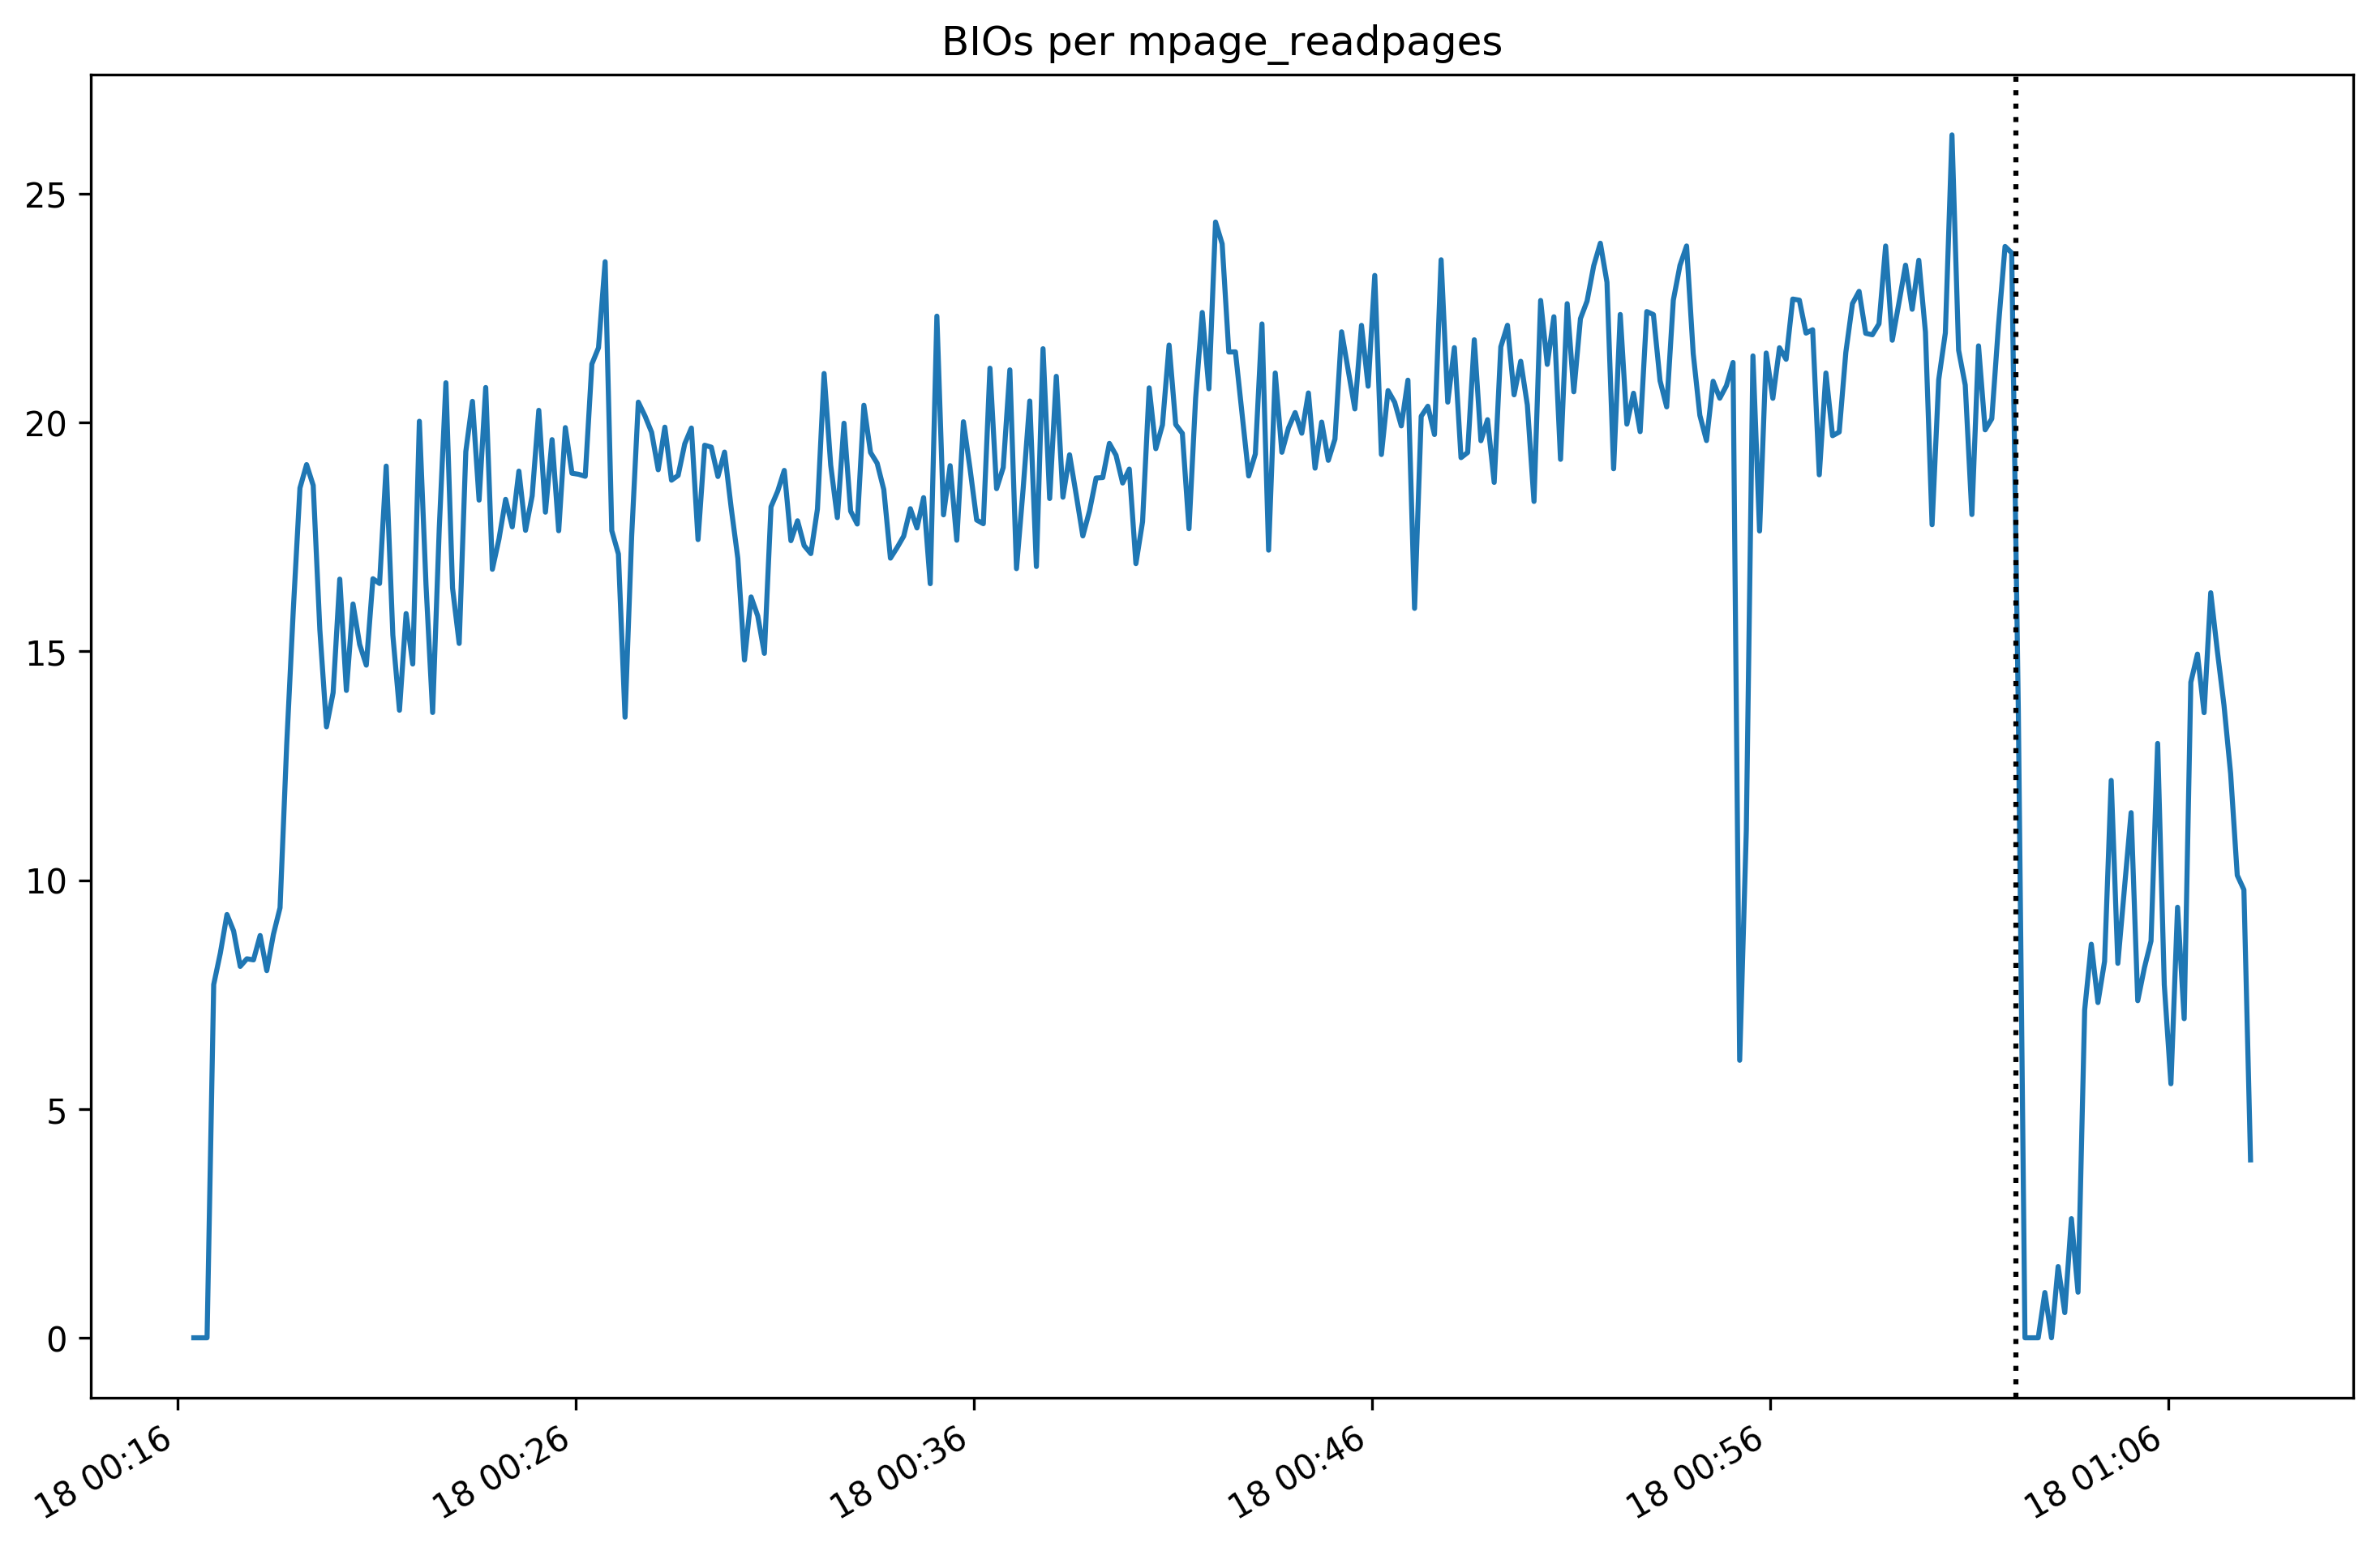

In [33]:
plot(ioreqs['mpage_readpages'] / ioreqs['bios'], title='BIOs per mpage_readpages')

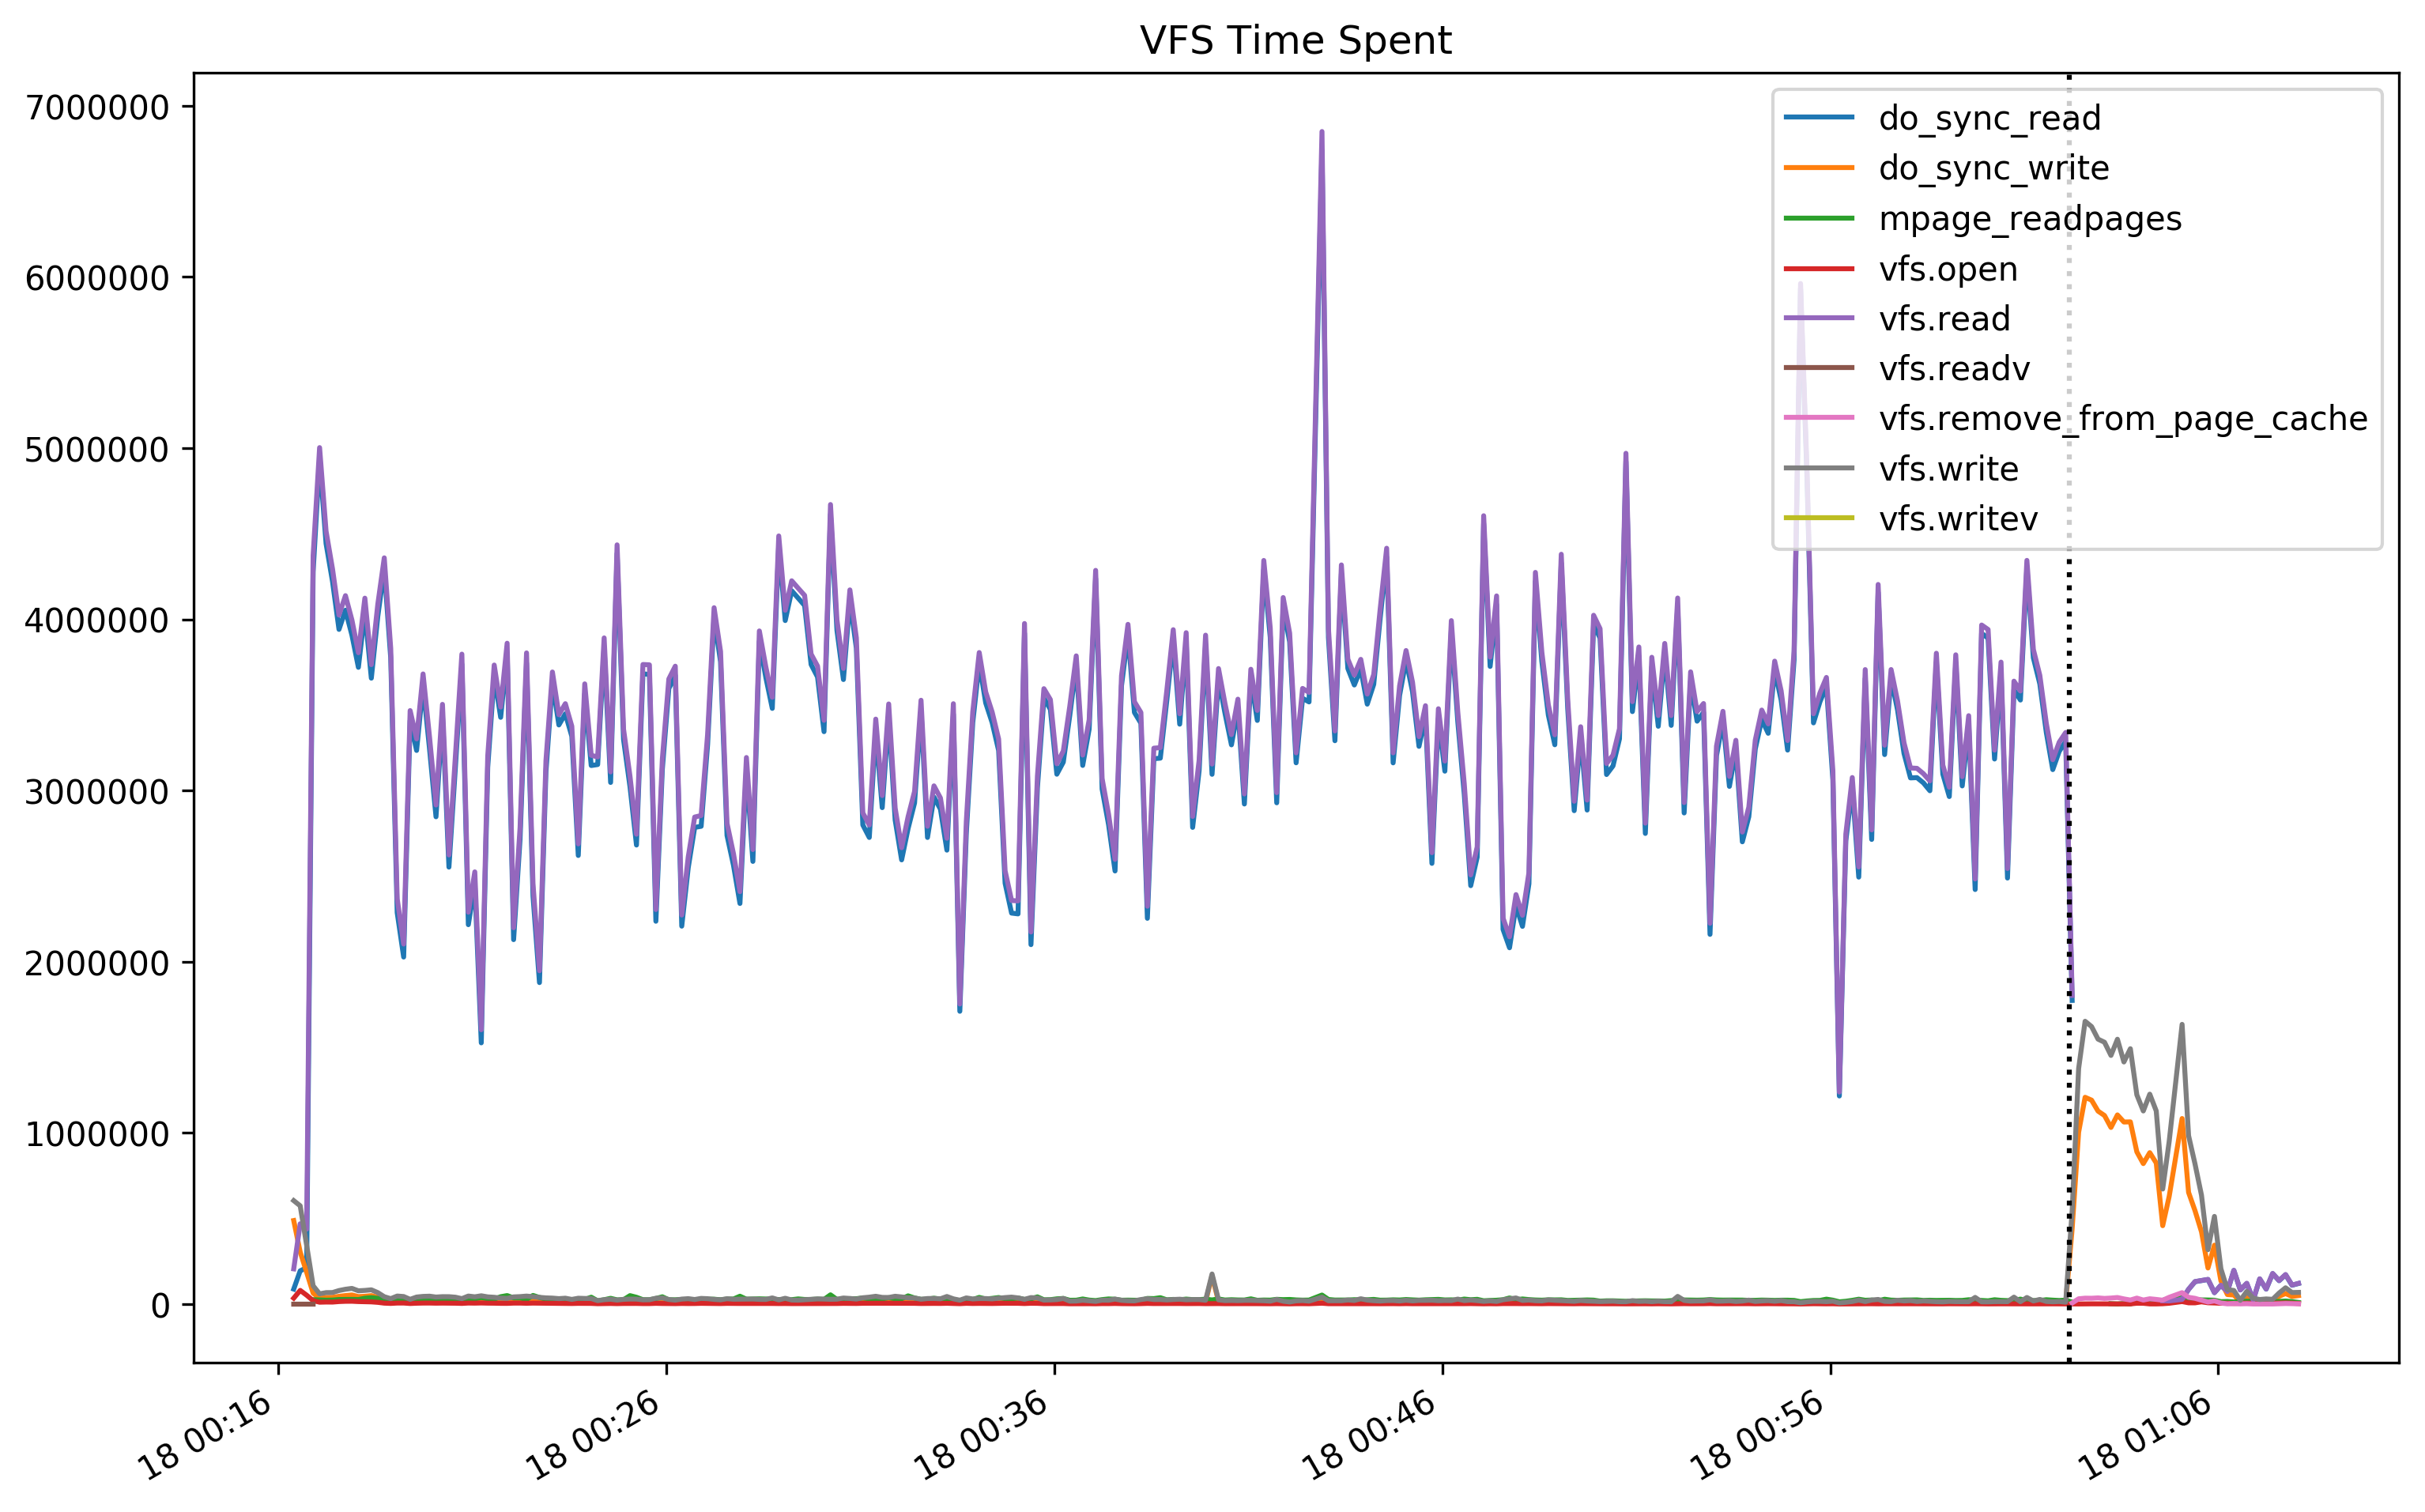

In [35]:
plot(vfstime, title="VFS Time Spent")